<a href="https://colab.research.google.com/github/azharul/textClassification_IMDB/blob/master/Text_classification_Bi_directional_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0-rc0


## Loading IMDB data

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


## Converting encoded reviews back to words

In [4]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
decode_review(train_data[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

## Data preparation

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
print(train_data[10])

[   4 1172 3404   10   10  328 1236    9    6   55  221 2989    5  146
  165  179  770   15   50  713   53  108  448   23   12   17  225   38
   76 4397   18  183    8   81   19   12   45 1257    8  135   15    2
  166    4  118    7   45    2   17  466   45    2    4   22  115  165
  764 6075    5 1030    8 2973   73  469  167 2127    2 1568    6   87
  841   18    4   22    4  192   15   91    7   12  304  273 1004    4
 1375 1172 2768    2   15    4   22  764   55 5773    5   14 4233 7444
    4 1375  326    7    4 4760 1786    8  361 1236    8  989   46    7
    4 2768   45   55  776    8   79  496   98   45  400  301   15    4
 1859    9    4  155   15   66    2   84    5   14   22 1534   15   17
    4  167    2   15   75   70  115   66   30  252    7  618   51    9
 2161    4 3130    5   14 1525    8 6584   15    2  165  127 1921    8
   30  179 2532    4   22    9  906   18    6  176    7 1007 1005    4
 1375  114    4  105   26   32   55  221   11   68  205   96    5    4
  192 

## Creating model

#### Bi-directional RNN with callback

In [28]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), 
                               input_shape=(5, 10)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation=tf.nn.relu))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 256)         148480    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Plotting model

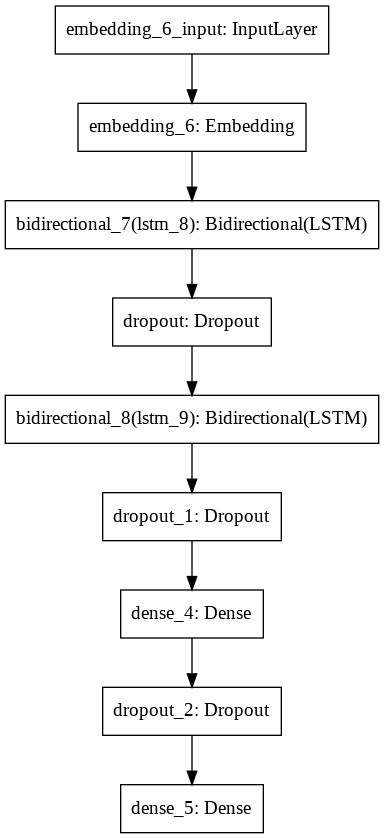

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

## Training with early stopping

In [32]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback],
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 284s 19ms/sample - loss: 0.6905 - acc: 0.5337 - val_loss: 0.6656 - val_acc: 0.6722
Epoch 2/40
15000/15000 [==============================] - 273s 18ms/sample - loss: 0.5986 - acc: 0.7091 - val_loss: 0.6266 - val_acc: 0.6931
Epoch 3/40
15000/15000 [==============================] - 273s 18ms/sample - loss: 0.5254 - acc: 0.7577 - val_loss: 0.4756 - val_acc: 0.7844
Epoch 4/40
15000/15000 [==============================] - 276s 18ms/sample - loss: 0.3554 - acc: 0.8649 - val_loss: 0.3684 - val_acc: 0.8459
Epoch 5/40
15000/15000 [==============================] - 275s 18ms/sample - loss: 0.2630 - acc: 0.9120 - val_loss: 0.3404 - val_acc: 0.8635
Epoch 6/40
15000/15000 [==============================] - 278s 19ms/sample - loss: 0.1949 - acc: 0.9393 - val_loss: 0.3590 - val_acc: 0.8695
Epoch 7/40
15000/15000 [==============================] - 280s 19ms/sample - loss: 0.1588 - acc: 0.9535 

In [33]:
results = model.evaluate(test_data, test_labels, verbose=0)

print(results)

[0.4453330716705322, 0.84144]


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

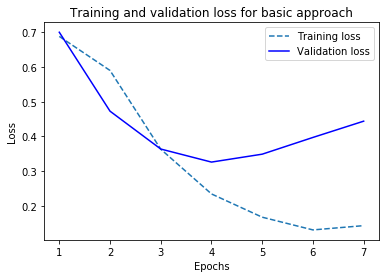

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for basic approach')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

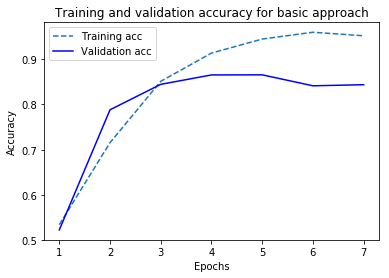

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for basic approach')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
